<h2>Imports</h2>
<ul>
    <li>Scikit-learn</li>
    <li>Pandas</li>
    <li>Numpy</li>
    <li>Matplotlib</li>
    <li>Seaborn</li>
    <li>Ucimlrepo</li>
</ul>

In [152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

# Scikit-Learn imports
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb


# Dataset
from ucimlrepo import fetch_ucirepo

<h2>Fetch Dataset</h2>

In [3]:
# fetch dataset 
parkinsons_telemonitoring = fetch_ucirepo(id=189) 
  
# data (as pandas dataframes) 
X = parkinsons_telemonitoring.data.features 
y = parkinsons_telemonitoring.data.targets 

<h3>Visualize X</h3>
<h5><b>NOTE:</b> You have to zoom to see the head of the dataset in this table</h5>

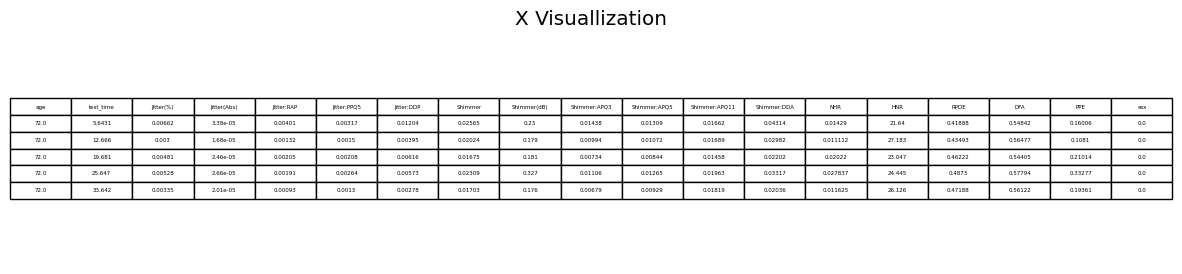

In [38]:
plt.figure(figsize=(15,3))
plt.table(cellText=pd.DataFrame(X.head().values).values, colLabels=X.columns, cellLoc = 'center', loc='center')
plt.axis('off')
plt.title("X Visuallization")
plt.show()

<h3>Visualize y</h3>
<h5><b>NOTE:</b> You have to zoom to see the head of the dataset in this table</h5>

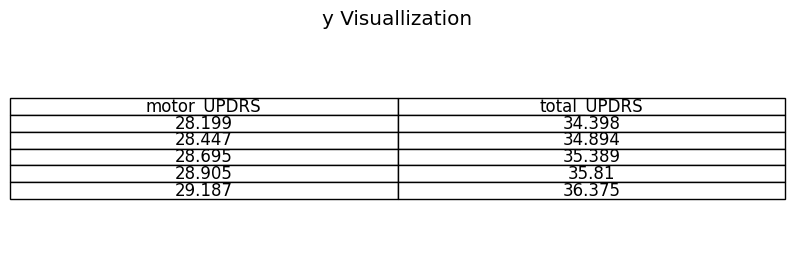

In [39]:
plt.figure(figsize=(10,3))
plt.table(cellText=pd.DataFrame(y.head().values).values, colLabels=y.columns, cellLoc = 'center', loc='center')
plt.axis('off')
plt.title("y Visuallization")
plt.show()

<h2>Discretize</h2>
<h5><b>NOTE:</b> Az you can see we have 2 lables for each record and it is continuous so we have to dicretize it</h5>
<p><b>Approach:</b> Apply binary discretization on both labels and make a new column of all 4 types of combinations of labels. To do this we calculate the min, max and mean of each column and cut every data between min to mean in 0 class and every data between mean and max into 1 class</p>

In [99]:
# Min value of motor UPDRS
min_motor_updrs = y['motor_UPDRS'].min()  # 5.0377

# Max value of motor UPDRS
max_motor_updrs = y['motor_UPDRS'].max()  # 39.511

# Mean of motor UPDRS values
mean_motor_updrs = y['motor_UPDRS'].mean()  # 21.29622854468085

# Min value of total UPDRS
min_total_updrs = y['total_UPDRS'].min()  # 7.0

# Max value of total UPDRS 
max_total_updrs = y['total_UPDRS'].max()  # 54.992

# Mean of total UPDRS values
mean_total_updrs = y['total_UPDRS'].mean()  # 29.01894228085106

# To save new labels temporary
y_motor_updrs = []  # Will be lenggth of 5875
y_total_updrs = []  # Will be lenggth of 5875

# To save final labels - values from 0, 1, 2, 3
y_final_labels = []  # Will be lenggth of 5875

for i in range(len(y['motor_UPDRS'].values)):
    # Motor UPDRS
    if min_motor_updrs <= y['motor_UPDRS'][i] < mean_motor_updrs:
        y_motor_updrs.append(0)
    elif mean_motor_updrs <= y['motor_UPDRS'][i] <= max_motor_updrs:
        y_motor_updrs.append(1)
    else:
        raise Exception('NOT VALID')
    
    # Total UPDRS
    if min_total_updrs <= y['total_UPDRS'][i] < mean_total_updrs:
        y_total_updrs.append(0)
    elif mean_total_updrs <= y['total_UPDRS'][i] <= max_total_updrs:
        y_total_updrs.append(1)
    else:
        raise Exception('NOT VALID')
    
# Final labels
for i in range(len(y_total_updrs)):
    if y_total_updrs[i] == 1 and y_motor_updrs[i] == 1:
        y_final_labels.append(0)
    elif y_total_updrs[i] == 1 and y_motor_updrs[i] == 0:
        y_final_labels.append(1)
    elif y_total_updrs[i] == 0 and y_motor_updrs[i] == 1:
        y_final_labels.append(2)
    elif y_total_updrs[i] == 0 and y_motor_updrs[i] == 0:
        y_final_labels.append(3)
    else:
        raise Exception('NOT VALID')

y_final_labels = pd.DataFrame(y_final_labels)

<h2>Pre processing</h2>
<ul>
    <li>Handle Missing values (Already Done)</li>
    <li>Normalize</li>
    <li>Handle categorical feaures (Already Done)</li>
    <li>Feature selection by scaling down correlated features</li>
</ul>

<h4><b>NOTE:</b> As you can see in the dataset explanation, there is no missing value and all of the features are either integral or float numbers, so these 2 steps are already done.</h4>

<h2>Step 1: Normalization</h2>
<h4><b>Approach</b></h4>
<p>Approach is to use standard normalization</p>

In [77]:
# Make an instance of Scalar normalizer
scalar = StandardScaler()
normalized_X = scalar.fit_transform(X)
normalized_X = pd.DataFrame(normalized_X, columns=X.columns)

In [78]:
# Show normalized data
print(normalized_X)

           age  test_time  Jitter(%)  Jitter(Abs)  Jitter:RAP  Jitter:PPQ5  \
0     0.815695  -1.632090   0.082905    -0.284379    0.327453    -0.028637   
1     0.815695  -1.500676  -0.560793    -0.756869   -0.533746    -0.476212   
2     0.815695  -1.369410  -0.238944    -0.540080   -0.300038    -0.320767   
3     0.815695  -1.257773  -0.155370    -0.484493   -0.344859    -0.170682   
4     0.815695  -1.108169  -0.498557    -0.665151   -0.658604    -0.529814   
...        ...        ...        ...          ...         ...          ...   
5870 -0.431361   0.934231  -0.372307    -0.359422   -0.421694    -0.427970   
5871 -0.431361   1.066152  -0.566128    -0.537300   -0.575365    -0.484252   
5872 -0.431361   1.196763  -0.473663    -0.537300   -0.469717    -0.377049   
5873 -0.431361   1.326064  -0.594579    -0.659592   -0.546552    -0.473532   
5874 -0.431361   1.457050  -0.592801    -0.637357   -0.524142    -0.433331   

      Jitter:DDP   Shimmer  Shimmer(dB)  Shimmer:APQ3  Shimmer:

<h2>Step 2: Feature Selection</h2>
<h4>As you can see down below there are two groups of features which are tightly correlated</h4>
<b>Group no1</b>
<ul>
    <li>jitter(%)</li>
    <li>jitter:RAP</li>
    <li>jitter:PPQ5</li>
    <li>jitter:DDP</li>
</ul>
<b>Group no2</b>
<ul>
    <li>Shimmer</li>
    <li>Shimmer(dB)</li>
    <li>Shimmer:APQ3</li>
    <li>Shimmer:APQ5</li>
    <li>Shimmer:APQ11</li>
    <li>Shimmer:DDA</li>
</ul>
<h4><b>Approach</b></h4>
<p>Approach is to scale down each group to one feature using PCA</p>
<p><b>NOTE:</b> I applied normalization before appling PCA becasue practically it show that makes PCA do better</p>

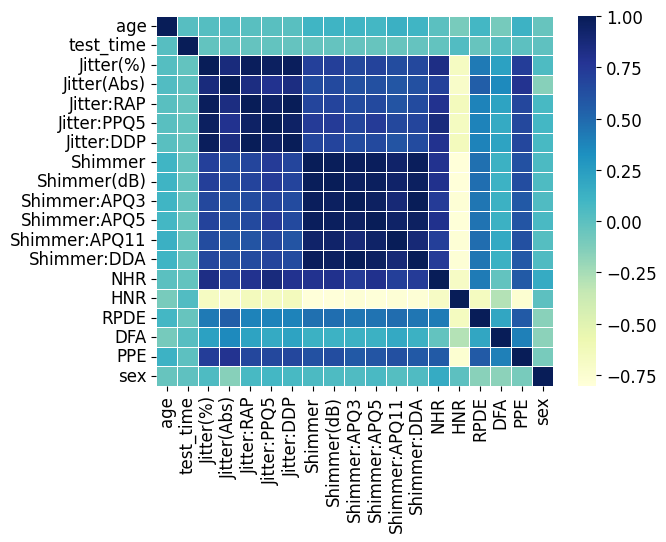

In [58]:
# Correlation heatmap
sb.heatmap(X.corr(), annot=False, cmap='YlGnBu', fmt='.2f', linewidths=.5)
plt.show()

In [96]:
# Jitter correlated columns
jitter_selected = normalized_X[['Jitter(%)', 'Jitter:RAP', 'Jitter:PPQ5', 'Jitter:DDP']]

# Shimmer correlated columns
shimmer_selected = normalized_X[['Shimmer', 'Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'Shimmer:APQ11', 'Shimmer:DDA']]

# Make an instance from PCA
pca_jitter = PCA(n_components=1)
pca_shimmer = PCA(n_components=1)

# Scaling down Jitter correlated features
jitter_selected_feature = pca_jitter.fit_transform(jitter_selected)
jitter_selected_feature = pd.DataFrame(jitter_selected_feature, columns=['Jitter'])

# Scaling down Shimmer correlated features
shimmer_selected_feature = pca_shimmer.fit_transform(shimmer_selected)
shimmer_selected_feature = pd.DataFrame(shimmer_selected_feature, columns=['Shimmer'])

# Final training data has 11 features
final_X = pd.concat([normalized_X[['age', 'test_time', 'Jitter(Abs)', 'NHR', 'HNR', 'RPDE', 'DFA', 'PPE', 'sex']], jitter_selected_feature, shimmer_selected_feature], axis=1)

<h2>Split dataset</h2>
<ul>
    <li>Train data (70%)</li>
    <li>Test data (30%)</li>
</ul>

In [100]:
X_train, X_test, y_train, y_test = train_test_split(final_X, y_final_labels, test_size=0.3, random_state=42)

# Size of Train and Test data
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4112, 11)
(1763, 11)
(4112, 1)
(1763, 1)


<h1>Training Part</h1>
<h3>Decision Tree</h3>
<b>Without using k fold cross validation</b>

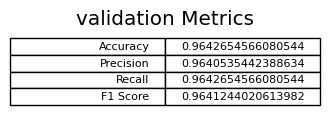

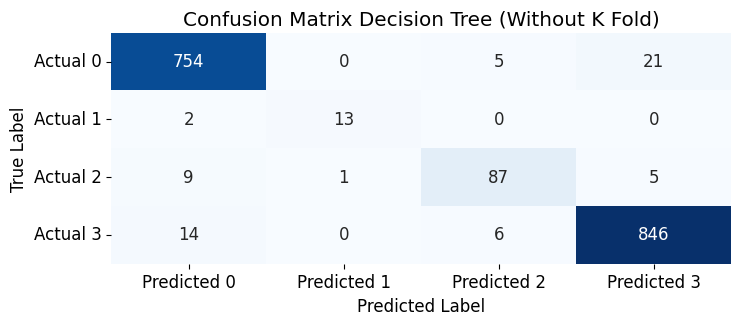

Decision Tree parameters:
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}


In [139]:
# Make an instance from decision tree
decision_tree_1 = DecisionTreeClassifier(random_state=42)

# Train model
decision_tree_1.fit(X_train, y_train)

# Test model
y_pred_DT_without_kfold = decision_tree_1.predict(X_test)
acc_DT_without_kfold = accuracy_score(y_test, y_pred_DT_without_kfold)
pre_DT_without_kfold = precision_score(y_test, y_pred_DT_without_kfold, average='weighted')
rec_DT_without_kfold = recall_score(y_test, y_pred_DT_without_kfold, average='weighted')
f1_DT_without_kfold = f1_score(y_test, y_pred_DT_without_kfold, average='weighted')
confmat_DT_without_kfold = confusion_matrix(y_test, y_pred_DT_without_kfold)
metrics_DT_without_kfold = [['Accuracy', acc_DT_without_kfold], ['Precision', pre_DT_without_kfold], ['Recall', rec_DT_without_kfold], ['F1 Score', f1_DT_without_kfold]]

# Plot Metrics
plt.figure(figsize=(4, 1))
plt.table(metrics_DT_without_kfold, loc='center')
plt.axis('off')
plt.title('validation Metrics')
plt.show()

# Plot confusion matrix
plt.figure(figsize=(8, 3))
sb.heatmap(confmat_DT_without_kfold, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1', 'Predicted 2', 'Predicted 3'],
            yticklabels=['Actual 0', 'Actual 1', 'Actual 2', 'Actual 3'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Decision Tree (Without K Fold)')
plt.show()

# Decision Tree parameters
print('Decision Tree parameters:')
print(decision_tree_1.get_params())

<b>With using k fold cross validation</b>

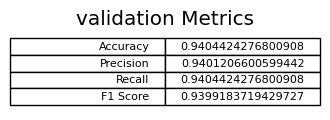

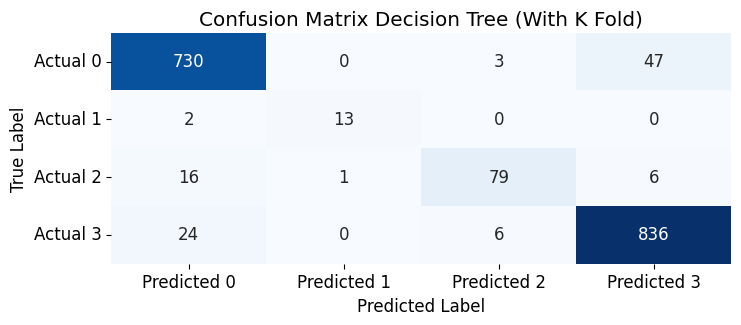

Decision Tree parameters:
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 11, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}
Best Hyper Parameters:
{'max_depth': 11, 'min_samples_split': 2}


In [147]:
# Make an instance from decision tree
decision_tree_2 = DecisionTreeClassifier(random_state=42)

# Aplly k fold
param_grid = {
    'max_depth': [7, 9, 11],
    'min_samples_split': [2, 5, 10],
}
grid_search_DT = GridSearchCV(estimator=decision_tree_2, param_grid=param_grid, scoring='accuracy', cv=5)

# Train model
grid_search_DT.fit(X_train, y_train)

# Test model
y_pred_DT_with_kfold = grid_search_DT.best_estimator_.predict(X_test)
acc_DT_with_kfold = accuracy_score(y_test, y_pred_DT_with_kfold)
pre_DT_with_kfold = precision_score(y_test, y_pred_DT_with_kfold, average='weighted')
rec_DT_with_kfold = recall_score(y_test, y_pred_DT_with_kfold, average='weighted')
f1_DT_with_kfold = f1_score(y_test, y_pred_DT_with_kfold, average='weighted')
confmat_DT_with_kfold = confusion_matrix(y_test, y_pred_DT_with_kfold)
metrics_DT_with_kfold = [['Accuracy', acc_DT_with_kfold], ['Precision', pre_DT_with_kfold], ['Recall', rec_DT_with_kfold], ['F1 Score', f1_DT_with_kfold]]

# Plot Metrics
plt.figure(figsize=(4, 1))
plt.table(metrics_DT_with_kfold, loc='center')
plt.axis('off')
plt.title('validation Metrics')
plt.show()

# Plot confusion matrix
plt.figure(figsize=(8, 3))
sb.heatmap(confmat_DT_with_kfold, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1', 'Predicted 2', 'Predicted 3'],
            yticklabels=['Actual 0', 'Actual 1', 'Actual 2', 'Actual 3'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Decision Tree (With K Fold)')
plt.show()

# Decision Tree parameters
print('Decision Tree parameters:')
print(grid_search_DT.best_estimator_.get_params())
print("Best Hyper Parameters:")
print(grid_search_DT.best_params_)


<h3>Random Forest</h3>
<b>Without using k fold cross validation</b>

e:\tuts\Machine_Learning_Fall_1402\Sajedi\Projects\Compare_Multiple_ML_Methods_on_Parkinson_Dataset\.venv\Lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


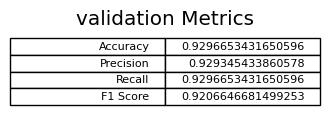

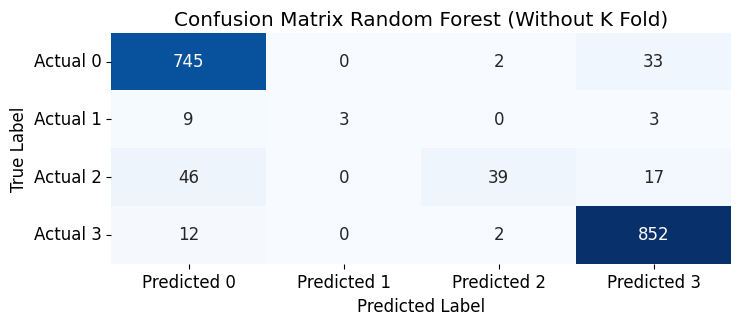

Decision Tree parameters:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [149]:
# Make an instance of random forest
random_forest_1 = RandomForestClassifier(random_state=42)

# Train model
random_forest_1.fit(X_train, y_train)

# Test model
y_pred_RF_without_kfold = random_forest_1.predict(X_test)
acc_RF_without_kfold = accuracy_score(y_test, y_pred_RF_without_kfold)
pre_RF_without_kfold = precision_score(y_test, y_pred_RF_without_kfold, average='weighted')
rec_RF_without_kfold = recall_score(y_test, y_pred_RF_without_kfold, average='weighted')
f1_RF_without_kfold = f1_score(y_test, y_pred_RF_without_kfold, average='weighted')
confmat_RF_without_kfold = confusion_matrix(y_test, y_pred_RF_without_kfold)
metrics_RF_without_kfold = [['Accuracy', acc_RF_without_kfold], ['Precision', pre_RF_without_kfold], ['Recall', rec_RF_without_kfold], ['F1 Score', f1_RF_without_kfold]]

# Plot Metrics
plt.figure(figsize=(4, 1))
plt.table(metrics_RF_without_kfold, loc='center')
plt.axis('off')
plt.title('validation Metrics')
plt.show()

# Plot confusion matrix
plt.figure(figsize=(8, 3))
sb.heatmap(confmat_RF_without_kfold, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1', 'Predicted 2', 'Predicted 3'],
            yticklabels=['Actual 0', 'Actual 1', 'Actual 2', 'Actual 3'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Random Forest (Without K Fold)')
plt.show()

# Decision Tree parameters
print('Random Forest parameters:')
print(random_forest_1.get_params())

<h3>Random Forest</h3>
<b>With using k fold cross validation</b>

e:\tuts\Machine_Learning_Fall_1402\Sajedi\Projects\Compare_Multiple_ML_Methods_on_Parkinson_Dataset\.venv\Lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
e:\tuts\Machine_Learning_Fall_1402\Sajedi\Projects\Compare_Multiple_ML_Methods_on_Parkinson_Dataset\.venv\Lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
e:\tuts\Machine_Learning_Fall_1402\Sajedi\Projects\Compare_Multiple_ML_Methods_on_Parkinson_Dataset\.venv\Lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
 

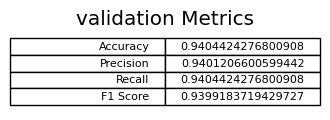

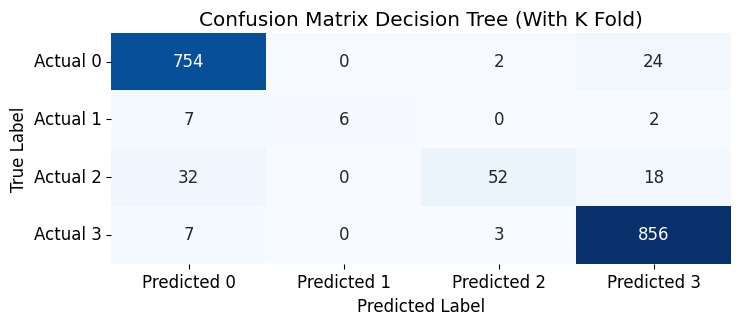

Decision Tree parameters:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 30, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Best Hyper Parameters:
{'criterion': 'entropy', 'max_depth': 30, 'min_samples_leaf': 1, 'n_estimators': 200}


In [151]:
# Make an instance from random forest
random_forest_2 = RandomForestClassifier(random_state=42)

# Aplly k fold
param_grid = {
    'n_estimators': [100, 200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [10, 20, 30],
    'min_samples_leaf': [1, 2, 4],
}
grid_search_RF = GridSearchCV(estimator=random_forest_2, param_grid=param_grid, scoring='accuracy', cv=5)

# Train model
grid_search_RF.fit(X_train, y_train)

# Test model
y_pred_RF_with_kfold = grid_search_RF.best_estimator_.predict(X_test)
acc_RF_with_kfold = accuracy_score(y_test, y_pred_RF_with_kfold)
pre_RF_with_kfold = precision_score(y_test, y_pred_RF_with_kfold, average='weighted')
rec_RF_with_kfold = recall_score(y_test, y_pred_RF_with_kfold, average='weighted')
f1_RF_with_kfold = f1_score(y_test, y_pred_RF_with_kfold, average='weighted')
confmat_RF_with_kfold = confusion_matrix(y_test, y_pred_RF_with_kfold)
metrics_RF_with_kfold = [['Accuracy', acc_RF_with_kfold], ['Precision', pre_RF_with_kfold], ['Recall', rec_RF_with_kfold], ['F1 Score', f1_RF_with_kfold]]

# Plot Metrics
plt.figure(figsize=(4, 1))
plt.table(metrics_DT_with_kfold, loc='center')
plt.axis('off')
plt.title('validation Metrics')
plt.show()

# Plot confusion matrix
plt.figure(figsize=(8, 3))
sb.heatmap(confmat_RF_with_kfold, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1', 'Predicted 2', 'Predicted 3'],
            yticklabels=['Actual 0', 'Actual 1', 'Actual 2', 'Actual 3'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Decision Tree (With K Fold)')
plt.show()

# Decision Tree parameters
print('Random Forest parameters:')
print(grid_search_RF.best_estimator_.get_params())
print("Best Hyper Parameters:")
print(grid_search_RF.best_params_)


<h3>XGBoost</h3>
<b>Without using k fold cross validation</b>

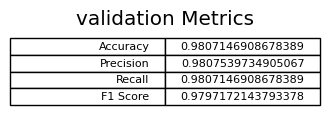

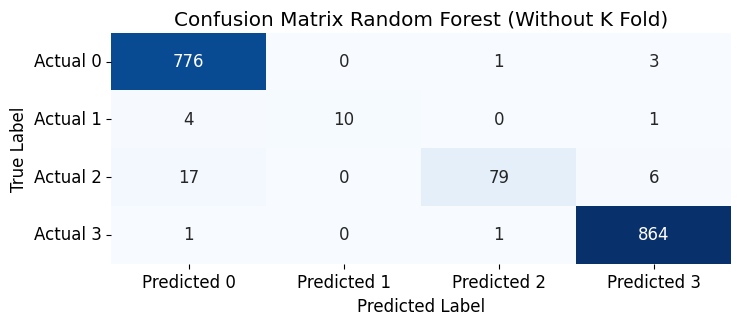

XGBoost parameters:
{'objective': 'multi:softprob', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


In [155]:
# Make an instance from XGBoost
xgb_classifier_1 = xgb.XGBClassifier(random_state=42) 

# Train model
xgb_classifier_1.fit(X_train, y_train)

# Test model
y_pred_XGB_without_kfold = xgb_classifier_1.predict(X_test)
acc_XGB_without_kfold = accuracy_score(y_test, y_pred_XGB_without_kfold)
pre_XGB_without_kfold = precision_score(y_test, y_pred_XGB_without_kfold, average='weighted')
rec_XGB_without_kfold = recall_score(y_test, y_pred_XGB_without_kfold, average='weighted')
f1_XGB_without_kfold = f1_score(y_test, y_pred_XGB_without_kfold, average='weighted')
confmat_XGB_without_kfold = confusion_matrix(y_test, y_pred_XGB_without_kfold)
metrics_XGB_without_kfold = [['Accuracy', acc_XGB_without_kfold], ['Precision', pre_XGB_without_kfold], ['Recall', rec_XGB_without_kfold], ['F1 Score', f1_XGB_without_kfold]]

# Plot Metrics
plt.figure(figsize=(4, 1))
plt.table(metrics_XGB_without_kfold, loc='center')
plt.axis('off')
plt.title('validation Metrics')
plt.show()

# Plot confusion matrix
plt.figure(figsize=(8, 3))
sb.heatmap(confmat_XGB_without_kfold, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1', 'Predicted 2', 'Predicted 3'],
            yticklabels=['Actual 0', 'Actual 1', 'Actual 2', 'Actual 3'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Random Forest (Without K Fold)')
plt.show()

# Decision Tree parameters
print('XGBoost parameters:')
print(xgb_classifier_1.get_params())


<h3>XGBoost</h3>
<b>With using k fold cross validation</b>

In [ ]:
# Make an instance from XGBoost
xgb_classifier_2 = xgb.XGBClassifier(random_state=42)

# Apply K Fold
param_grid = {
    'learning_rate': [0.01, 0.1],  
    'n_estimators': [50, 100],
    'max_depth': [5, 7],
    'min_child_weight': [3, 5],
    'gamma': [0.1, 0.2],
}
grid_search_XGB = GridSearchCV(estimator=xgb_classifier_2, param_grid=param_grid, cv=5, scoring='accuracy')

# Train model
grid_search_XGB.fit(X_train, y_train)

# Test model
y_pred_XGB_with_kfold = grid_search_XGB.best_estimator_.predict(X_test)
acc_XGB_with_kfold = accuracy_score(y_test, y_pred_XGB_with_kfold)
pre_XGB_with_kfold = precision_score(y_test, y_pred_XGB_with_kfold, average='weighted')
rec_XGB_with_kfold = recall_score(y_test, y_pred_XGB_with_kfold, average='weighted')
f1_XGB_with_kfold = f1_score(y_test, y_pred_XGB_with_kfold, average='weighted')
confmat_XGB_with_kfold = confusion_matrix(y_test, y_pred_XGB_with_kfold)
metrics_XGB_with_kfold = [['Accuracy', acc_XGB_with_kfold], ['Precision', pre_XGB_with_kfold], ['Recall', rec_XGB_with_kfold], ['F1 Score', f1_XGB_with_kfold]]

# Plot Metrics
plt.figure(figsize=(4, 1))
plt.table(metrics_XGB_with_kfold, loc='center')
plt.axis('off')
plt.title('validation Metrics')
plt.show()

# Plot confusion matrix
plt.figure(figsize=(8, 3))
sb.heatmap(confmat_XGB_with_kfold, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1', 'Predicted 2', 'Predicted 3'],
            yticklabels=['Actual 0', 'Actual 1', 'Actual 2', 'Actual 3'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Decision Tree (With K Fold)')
plt.show()

# Decision Tree parameters
print('XGBoost parameters:')
print(grid_search_XGB.best_estimator_.get_params())
print("Best Hyper Parameters:")
print(grid_search_XGB.best_params_)
